In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time
import gc

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections
import tensorflow as tf
from scipy.stats import randint as sp_randint
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
import time


import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras import regularizers
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

from keras_tqdm import TQDMNotebookCallback
from tqdm import tqdm_notebook,trange, tqdm

# Other Libraries
# from imblearn.datasets import fetch_datasets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
# from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import random

Using TensorFlow backend.


In [3]:
df = pd.read_csv("../data/creditcardfraud/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [5]:

X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

df.head()

Train: [265518 180305  42664 ...  29062  13766  17677] Test: [263020  11378 147283 ... 274532 269819  64170]
Train: [ 72227 114282  16818 ... 264471 191914 284017] Test: [202638  32978 128121 ... 244024 127667  48318]
Train: [ 20895 114622 167683 ... 244502 178972 218506] Test: [284352  82483  90981 ... 171224 168807 271602]
Train: [122248 181660 194400 ... 104631 277586  29432] Test: [225673  63348  68025 ... 279451  77554  76043]
Train: [241684 223467 136928 ...  86495 160550  49633] Test: [157557 204860  83760 ... 251478 178967 216850]


,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [6]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

df = df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()


,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
44826,1.290016,-0.500394,0.901969,-0.270398,0.365589,1.423329,-0.409332,0.035572,0.021253,0.165884,...,-0.053912,0.012365,-0.069669,-0.126948,0.214519,0.522820,-0.349772,0.007752,0.023554,0
42674,-0.286173,-0.511026,-7.896886,5.381020,-8.451162,7.963928,-7.862419,-2.376820,-11.949723,5.051356,...,0.645974,2.557944,0.926278,0.032795,0.638073,0.361887,0.444577,1.101923,0.205958,1
167625,-0.291204,0.400733,-2.371238,1.738138,0.205206,-1.569851,-0.825023,0.794977,-1.342212,1.667748,...,-0.148644,0.341718,0.732009,-0.144944,-0.360977,-0.074513,-0.013241,-0.889988,-0.451168,0
189587,0.641375,0.514327,0.909124,1.337658,-4.484728,3.245358,-0.417809,-0.762119,-2.506349,0.694164,...,0.445573,0.586829,0.594078,-0.252120,0.325439,0.562766,-0.256278,0.652674,0.319879,1
154633,0.000559,0.207075,-1.020632,1.496959,-4.490937,1.836727,0.627318,-2.735569,-1.546274,0.459822,...,0.443489,0.773631,0.860618,-0.304666,-0.155500,0.412166,-0.220080,0.392338,-0.020089,1


In [7]:
# Undersampling before cross validating (prone to overfit)
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [8]:
# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split
# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

classifiers = {
#     "LogisiticRegression": LogisticRegression(),
#     "KNearest": KNeighborsClassifier(),
#     "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [10]:

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  DecisionTreeClassifier Has a training score of 91.0 % accuracy score


In [11]:
from sklearn.model_selection import GridSearchCV



# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(1,100,1)), 
              "max_leaf_nodes": list(range(2,100,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), cv=5, tree_params, n_jobs=-1)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

SyntaxError: positional argument follows keyword argument (<ipython-input-11-1bcc0bbf3a7b>, line 8)

In [ ]:
grid_tree.best_estimator_

In [ ]:
fig, ax = plt.subplots()

labels = 'Fraud', 'No Fraud'

data = [df['Class'].value_counts()[1], df['Class'].value_counts()[0]]

print(data)

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d} samples".format(pct, absolute)

ax.pie(data, labels=labels, startangle=60, autopct=lambda pct: func(pct, data))

ax.axis('equal')


plt.show()

In [ ]:
scores = [x[1] for x in grid_tree.grid_scores_]

In [155]:

param_dist = {
              "n_neighbors": sp_randint(1, 20),
              "p": [1, 2]
}
start_time = time.time()
rand_kNN = RandomizedSearchCV(KNeighborsClassifier(), param_dist, cv=10, n_jobs=-1, n_iter=50)
rand_kNN.fit(X_train, y_train)
knn_clf = rand_kNN.best_estimator_
kNN_score = cross_val_score(knn_clf, X_train, y_train, cv=10)
print('kNN Cross Validation Score', round(kNN_score.mean() * 100, 2).astype(str) + '%')
print(str(i) + " " + str(scores) + "--- %s seconds ---" % (time.time() - start_time))

kNN Cross Validation Score 94.03%
49 [0.9385057471264368, 0.7619962201256417]--- 2.7277028560638428 seconds ---


In [13]:
rand_kNN.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

[10, 7, 12, 10, 10, 16, 8, 8, 2, 16, 3, 11, 16, 1, 10, 9, 11, 13, 19, 5, 15, 10, 1, 1, 2, 9, 6, 1, 13, 3, 11, 19, 1, 10, 3, 6, 6, 2, 7, 2, 16, 6, 1, 7, 4, 15, 10, 12, 14, 3] [2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2] [0.940279542566709, 0.9339263024142312, 0.9415501905972046, 0.940279542566709, 0.940279542566709, 0.9390088945362135, 0.9440914866581956, 0.9390088945362135, 0.940279542566709, 0.9390088945362135, 0.9466327827191868, 0.9377382465057179, 0.9390088945362135, 0.9390088945362135, 0.9415501905972046, 0.9351969504447268, 0.9428208386277002, 0.9440914866581956, 0.940279542566709, 0.940279542566709, 0.9377382465057179, 0.940279542566709, 0.9390088945362135, 0.9390088945362135, 0.9453621346886912, 0.9440914866581956, 0.9428208386277002, 0.9390088945362135, 0.9440914866581956, 0.9466327827191868, 0.9428208386277002, 0.940279542566709, 0.9390088945362135, 0.940279542566709, 0.9

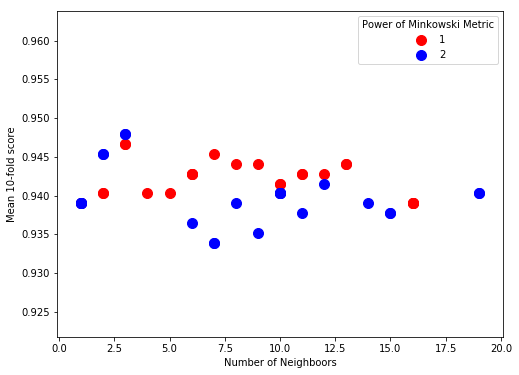

In [15]:
xs = [];
ys = [];
zs = [];
for i in range(0, len(rand_kNN.cv_results_['params'])):
    xs.append(rand_kNN.cv_results_['params'][i]['n_neighbors'])
    ys.append(rand_kNN.cv_results_['params'][i]['p'])
    zs.append(rand_kNN.cv_results_['mean_test_score'][i])



print(xs, ys, zs)
    
# fig = plt.figure(figsize=(8, 6))

# ax = fig.add_subplot(111)

# ax.scatter(xs, zs, label=ys)


# # ax.set_zlabel('Mean 10-fold score')

# plt.savefig("gridSearchCredit")

scatter_x = np.array(xs)
scatter_y = np.array(zs)
group = np.array(ys)
cdict = {1: 'red', 2: 'blue'}

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 100)
ax.set_xlabel('Number of Neighboors')
ax.set_ylabel('Mean 10-fold score')
ax.legend(title="Power of Minkowski Metric")
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

xs = [];
ys = [];
zs = [];

num = 0;

for score in grid_tree.grid_scores_:
#     print(score[0])
    if score[0]['criterion'] == 'entropy':
        
        if ((score[0]['max_depth'] % 5 == 0 and score[0]['max_leaf_nodes'] % 19 == 0)):
            xs.append(score[0]['max_depth'])
            ys.append(score[0]['max_leaf_nodes'])
            zs.append(score[1])
        num = num + 1


In [ ]:
fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs, ys, zs)

ax.set_xlabel('Depth Limit')
ax.set_ylabel('Child Node Limit')
ax.set_zlabel('Mean 5-fold score')

plt.savefig("gridSearchCredit")

plt.show()

In [13]:


n_inputs = X_train.shape[1]

def getModel(learning_rate, regularization, layers):
    undersample_model = Sequential();
    
    undersample_model.add(Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'))
    for i in range(0, layers):
        undersample_model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(regularization)))
    undersample_model.add(Dense(1, activation = "sigmoid"))

    undersample_model.compile(Adam(lr=learning_rate), loss=keras.losses.binary_crossentropy, metrics=['accuracy'])
    return undersample_model;

In [16]:
getModel(.001, .1, 2).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                992       
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 3,011
Trainable params: 3,011
Non-trainable params: 0
_________________________________________________________________


In [151]:
k = 10
num_epochs = 200
num_val_samples = len(X_train) // k
k_fold_results = [];

params = [[.001, .01, 2], [.001, .01, 1], [.001, .1, 1], [.001, .1, 2], [.0005, .1, 2], [.0005, .01, 2], [.0005, .1, 1], [.0005, .01, 1]]

for j in tqdm_notebook(params):
    print("using params! " + str(j))
    for i in tqdm_notebook(range(k)):
        undersample_model = getModel(j[0], j[1], j[2])
        print("TESTING FOLD " + str(i + 1))
        val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

        partial_train_data = np.concatenate(
            [X_train[:i * num_val_samples],
            X_train[(i + 1) * num_val_samples:]],
            axis=0)
        partial_train_targets = np.concatenate(
            [y_train[:i * num_val_samples],
            y_train[(i + 1) * num_val_samples:]],
            axis=0)

        history = undersample_model.fit(partial_train_data, partial_train_targets,
                            epochs=num_epochs, batch_size=32, verbose=0,
                            validation_data=(val_data, val_targets))

        k_fold_results.append([j, history]);
        print();
    

using params! [0.001, 0.01, 2]


TESTING FOLD 1

TESTING FOLD 2


KeyboardInterrupt: 

In [107]:
idx = 0;
means = []
for i in range(0, len(params)):
    curr_params, hist_obj = k_fold_results[idx]
    mean = {
        'val_loss':[0] * num_epochs,
        'val_acc':[0] * num_epochs,
        'loss':[0] * num_epochs,
        'acc':[0] * num_epochs,
        'params': curr_params
    }

    for j in range(0, k):   
        curr_params, hist_obj = k_fold_results[idx]
        
        for mean_key in hist_obj.history:
            for j in range(0, len(hist_obj.history[mean_key])):
                mean[mean_key][j] += hist_obj.history[mean_key][j]
        idx += 1
    for key in mean.keys():
        mean[key] = [x / k for x in mean[key]]

    means.append(mean);
        


In [108]:
len(means)

8

In [109]:
plt.figure(figsize=(20,15))

# counter1 = 1;
# counter2 = 4
# len()
maxAccs = []
minAccs = []

for mean in means:
    maxAccs.append(max(mean['val_acc']))
    minAccs.append(min(mean['val_acc']))
#     plt.subplot(4, 4, counter1)
#     plt.plot(mean['acc'])
#     plt.plot(mean['val_acc'])
#     plt.title('Model accuracy ' + str([x * 10 for x in mean['params']]))
#     plt.ylabel('Accuracy')
#     plt.xlabel('Epoch')
#     plt.legend(['Train', 'Test'], loc='upper left')
# #     plt.show()

#     counter1 += 1
    
#     plt.subplot(2, 4, counter2)
#     plt.plot(mean['loss'])
#     plt.plot(mean['val_loss'])
#     plt.title('Model loss ' + str([x * 10 for x in mean['params']]))
#     plt.ylabel('Loss')
#     plt.xlabel('Epoch')
#     plt.legend(['Train', 'Test'], loc='upper left')
# #     plt.show()
#     counter2 += 1;

print(maxAccs)
print(sorted(maxAccs))
# 2, 5, 7

print(minAccs)
print(sorted(minAccs))
# tops = [means[2], means[5], means[7]]
# plt.tight_layout()
# plt.show()

[0.9499999986245081, 0.9448717944132976, 0.948717947342457, 0.9487179473424568, 0.9499999990830054, 0.9487179473424568, 0.9474358971302326, 0.9499999990830054]
[0.9448717944132976, 0.9474358971302326, 0.9487179473424568, 0.9487179473424568, 0.948717947342457, 0.9499999986245081, 0.9499999990830054, 0.9499999990830054]
[0.8371794848870007, 0.7653846150789506, 0.7576923068517295, 0.744871796400119, 0.6833333334097496, 0.7153846153081991, 0.6141025648667262, 0.6371794875615682]
[0.6141025648667262, 0.6371794875615682, 0.6833333334097496, 0.7153846153081991, 0.744871796400119, 0.7576923068517295, 0.7653846150789506, 0.8371794848870007]


<Figure size 1440x1080 with 0 Axes>

In [84]:
tops[0]['val_acc'].index(max(tops[0]['val_acc']))

89

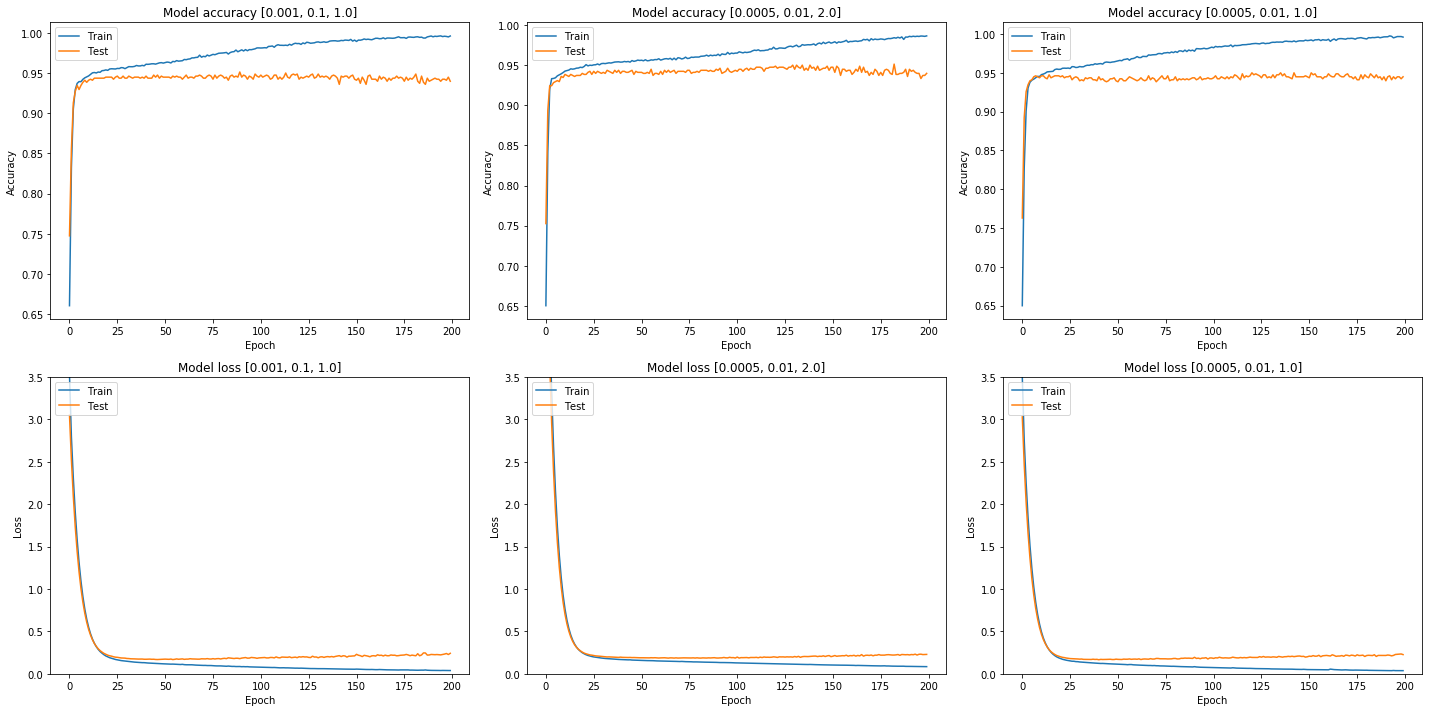

In [110]:
plt.figure(figsize=(20,10))

counter2 = 4;
counter1 = 1
for mean in tops:
    plt.subplot(2, 3, counter1)
    plt.plot(mean['acc'])
    plt.plot(mean['val_acc'])
    plt.title('Model accuracy ' + str([x * 10 for x in mean['params']]))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    counter1 += 1
    plt.subplot(2, 3, counter2)
    plt.plot(mean['loss'])
    plt.plot(mean['val_loss'])
    plt.title('Model loss ' + str([x * 10 for x in mean['params']]))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.ylim(0, 3.5)
#     plt.yscale("log")
    plt.legend(['Train', 'Test'], loc='upper left')
    counter2 += 1;

plt.tight_layout()
plt.show()

In [11]:
plt

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [18]:
best_dtc = DecisionTreeClassifier(max_depth=5, max_leaf_nodes=76)
adaboost = AdaBoostClassifier(base_estimator = best_dtc, n_estimators=1000)

In [19]:
adaboost_score = cross_val_score(adaboost, X_train, y_train, cv=10)
print('adaboost Cross Validation Score', round(adaboost_score.mean() * 100, 2).astype(str) + '%')

adaboost Cross Validation Score 94.92%


In [13]:
random.randint(1, 1000)

260

In [154]:
xs = [];
ys = [];
zs = [];
start_time = time.time()
for i in range(0, 50):
    n = random.randint(1, 1000)
    print("TESTING WITH " + str(n))
    best_dtc = DecisionTreeClassifier(max_depth=5, max_leaf_nodes=76)
    adaboost = AdaBoostClassifier(base_estimator = best_dtc, n_estimators=n)
#     best_dtc2 = DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10)
#     adaboost2 = AdaBoostClassifier(base_estimator= best_dtc2)
    adaboost_score = cross_val_score(adaboost, X_train, y_train, cv=10, n_jobs=-1)
#     adaboost_score2 = cross_val_score(adaboost2, X_train, y_train, cv=10, n_jobs=-1)
#     zs.append(adaboost_score2)
    ys.append(adaboost_score.mean())
    xs.append(n)
    print('adaboost Cross Validation Score', round(adaboost_score.mean() * 100, 2).astype(str) + '%')
#     print('adaboost 2 Cross Validation Score', round(adaboost_score2.mean() * 100, 2).astype(str) + '%')    
print(str(i) + " " + str(scores) + "--- %s seconds ---" % (time.time() - start_time))


TESTING WITH 63
adaboost Cross Validation Score 94.16%
TESTING WITH 92
adaboost Cross Validation Score 93.77%
TESTING WITH 538
adaboost Cross Validation Score 93.77%
TESTING WITH 506
adaboost Cross Validation Score 93.9%
TESTING WITH 843
adaboost Cross Validation Score 93.77%
TESTING WITH 321
adaboost Cross Validation Score 93.52%
TESTING WITH 503
adaboost Cross Validation Score 94.03%
TESTING WITH 954
adaboost Cross Validation Score 94.41%
TESTING WITH 493
adaboost Cross Validation Score 94.03%
TESTING WITH 744
adaboost Cross Validation Score 94.15%
TESTING WITH 595
adaboost Cross Validation Score 94.15%
TESTING WITH 563
adaboost Cross Validation Score 93.77%
TESTING WITH 941
adaboost Cross Validation Score 94.03%
TESTING WITH 277
adaboost Cross Validation Score 93.9%
TESTING WITH 775
adaboost Cross Validation Score 93.77%
TESTING WITH 413
adaboost Cross Validation Score 93.77%
TESTING WITH 223
adaboost Cross Validation Score 94.16%
TESTING WITH 918
adaboost Cross Validation Score 93.

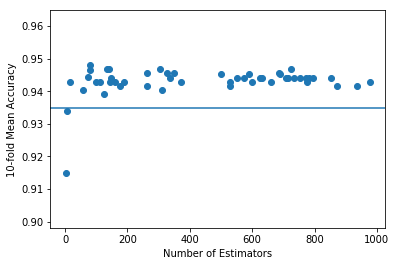

In [42]:
plt.xlabel("Number of Estimators")
plt.ylabel("10-fold Mean Accuracy")
plt.axhline(.935)
plt.scatter(xs, ys) #382 max

In [157]:
start_time = time.time()
param_dist = {
              "kernel": ["linear", "rbf", "sigmoid"],
              "C": sp_randint(1, 300),
}
svm = RandomizedSearchCV(SVC(), param_dist, cv=10, n_jobs=6, n_iter=50)
svm.fit(X_train, y_train)
svm_clf = svm.best_estimator_
svm_score = cross_val_score(svm_clf, X_train, y_train, cv=10)
print('svm Cross Validation Score', round(svm_score.mean() * 100, 2).astype(str) + '%')
print(str(i) + " " + str(scores) + "--- %s seconds ---" % (time.time() - start_time))

svm Cross Validation Score 93.64%
49 [0.9385057471264368, 0.7619962201256417]--- 50.589667320251465 seconds ---


In [80]:
svm_clf

SVC(C=199, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [81]:
svm.cv_results_

{'mean_fit_time': array([0.0103723 , 0.02583103, 0.00837767, 0.00837786, 0.02662878,
        0.02632964, 0.00826299, 0.68068182, 0.00767193, 0.02563443,
        5.2693043 , 0.62862086, 0.00897577, 0.02613058, 0.00746565,
        0.00757961, 6.01680679, 0.02533529, 2.90652506, 0.02652998,
        0.11908123, 0.02194047, 0.00817802, 5.98389213, 6.39888511,
        0.02463396, 0.02433503, 0.02594106, 0.02283905, 0.00768013,
        4.3449738 , 1.12359676, 0.72575884, 5.92066405, 0.16545646,
        0.01017282, 4.95115802, 0.00797882, 0.00718062, 0.02363675,
        0.90198987, 0.02722695, 0.02932112, 0.00857692, 0.00867701,
        0.21552351, 0.02672889, 0.02353647, 0.00777946, 0.0083776 ,
        3.64265785, 0.0280273 , 0.00857749, 3.99551167, 1.80666425,
        0.02533519, 0.00748339, 0.0077569 , 1.17625096, 0.02523291,
        0.00897567, 0.00977373, 0.00907037, 5.12040267, 0.02593324,
        0.02274134, 0.00746949, 0.12077692, 0.00667725, 0.02492781,
        0.007375  , 0.0222378 ,

In [82]:
kernelParams = {
    'linear' : {
        'xs': [],
        'ys': [],
    },
    'rbf': {
        'xs': [],
        'ys': [],
    },
    'sigmoid': {
        'xs': [],
        'ys': [],
    }
}

In [83]:

for i in range(0, len(svm.cv_results_['params'])):
    kernelParams[svm.cv_results_['params'][i]['kernel']]['xs'].append(svm.cv_results_['params'][i]['C'])
    kernelParams[svm.cv_results_['params'][i]['kernel']]['ys'].append(svm.cv_results_['mean_test_score'][i])
    

Text(0.5,0,'C penalty')

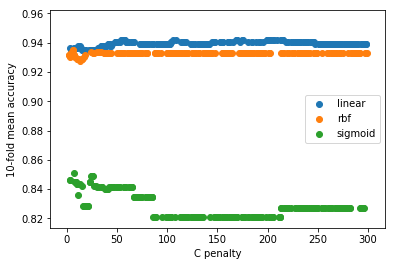

In [84]:
legendNames = [];
for x in kernelParams.keys():
    legendNames.append(x)
    plt.scatter(kernelParams[x]['xs'], kernelParams[x]['ys'])
plt.legend(legendNames)
plt.ylabel("10-fold mean accuracy")
plt.xlabel("C penalty")

In [14]:
resultsFinal = [
    [],
    [],
    [],
    [],
    []
];
print(len(X_train))
for i in range(1, 11):
    gc.collect()
    y_train_subset = y_train[:int((len(X_train)/10) * i)]
    X_train_subset = X_train[:int((len(X_train)/10) * i)]
    print(str(len(X_train)) + " " + str(len(y_train)))
    print(str(len(X_train_subset)) + " " + str(len(y_train_subset)))

    bestModels = [
        DecisionTreeClassifier(max_depth=200, max_leaf_nodes=76),
        getModel(.001, .1, 1),
        KNeighborsClassifier(n_neighbors=3, p=2),
        AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=200, max_leaf_nodes=76), n_estimators=17),
        SVC(kernel="linear", C=199)
    ]
    
    for j in range(0, len(bestModels)):
        start_time = time.time()
        if j == 1:
            bestModels[j].fit(X_train_subset, y_train_subset, epochs=25, batch_size=32, verbose=0)
        else: 
            bestModels[j].fit(X_train_subset, y_train_subset)
    
        predicAll = bestModels[j].predict(original_Xtest)
        predicSub = bestModels[j].predict(X_test)
        scores = [roc_auc_score(y_test, predicSub), roc_auc_score(original_ytest, predicAll)]
        resultsFinal[j].append(scores)
        print(str(i) + " " + str(scores) + "--- %s seconds ---" % (time.time() - start_time))
    

787
787 787
78 78
1 [0.8982758620689655, 0.8601405214590055]--- 0.02293848991394043 seconds ---
1 [0.9510971786833856, 0.7217568161198076]--- 3.2842140197753906 seconds ---
1 [0.9224660397074191, 0.7338694974331883]--- 0.2513272762298584 seconds ---
1 [0.9064263322884012, 0.8847409285886555]--- 0.024934768676757812 seconds ---
1 [0.9097701149425287, 0.8071941072433476]--- 0.07380151748657227 seconds ---
787 787
157 157
2 [0.8525600835945663, 0.7909186113950364]--- 0.015957355499267578 seconds ---
2 [0.9497387669801463, 0.8680126876299198]--- 2.0824291706085205 seconds ---
2 [0.9258098223615465, 0.7322559088351154]--- 0.4927067756652832 seconds ---
2 [0.8652560083594566, 0.7930816671069103]--- 0.03391122817993164 seconds ---
2 [0.9006792058516196, 0.6858130175255246]--- 0.1047203540802002 seconds ---
787 787
236 236
3 [0.8927899686520375, 0.8155830811502992]--- 0.01695537567138672 seconds ---
3 [0.9735632183908046, 0.42469366580340634]--- 2.49033784866333 seconds ---
3 [0.92126436781609

In [143]:
resultsFinal

[[[0.8683385579937304, 0.8093090711242291],
  [0.8970741901776385, 0.7694683986425184],
  [0.8903866248693835, 0.5525607823320662],
  [0.8879832810867294, 0.8161151418924352],
  [0.8547021943573668, 0.8417328348052784],
  [0.9131138975966562, 0.7904244139974504],
  [0.8764890282131661, 0.805268818979477],
  [0.9143155694879833, 0.786311485764818],
  [0.9315569487983283, 0.7653402174037877],
  [0.9155172413793102, 0.5990924999712884]],
 [[0.9703239289446186, 0.7456391655564871],
  [0.9633228840125393, 0.8747590922272117],
  [0.957471264367816, 0.9280696943943588],
  [0.9635318704284223, 0.7468000987677006],
  [0.9654127481713688, 0.8535572343034006],
  [0.9665621734587252, 0.9044366867456042],
  [0.9657262277951935, 0.5861732038060019],
  [0.9725182863113898, 0.39275342241567424],
  [0.9631138975966563, 0.6190492639796492],
  [0.9728317659352141, 0.7665235815063224]],
 [[0.8997387669801463, 0.7727931950776934],
  [0.9248693834900731, 0.7483733117613957],
  [0.9306165099268546, 0.7584542

In [15]:
def plotForAlgo(plt, selector, title):
    xs1 = [];
    ys1 = [];
    ys2 = [];
    otherCounter = 0
    for i in resultsFinal:
        if otherCounter == selector:
            counter = 1;
            for j in i:
                xs1.append(counter * 10)
                counter += 1;
                ys1.append(j[0])
                ys2.append(j[1])
        otherCounter+=1;
    
    plt.subplot(3, 3, selector + 1)
    plt.plot(xs1, ys1)
    plt.plot(xs1, ys2)
    plt.title(title)
    plt.xlabel("Percent of Training Dataset")
    plt.ylabel("ROC-AUC Score")

    plt.legend(["20% undersampled subset", "Entire Dataset"])


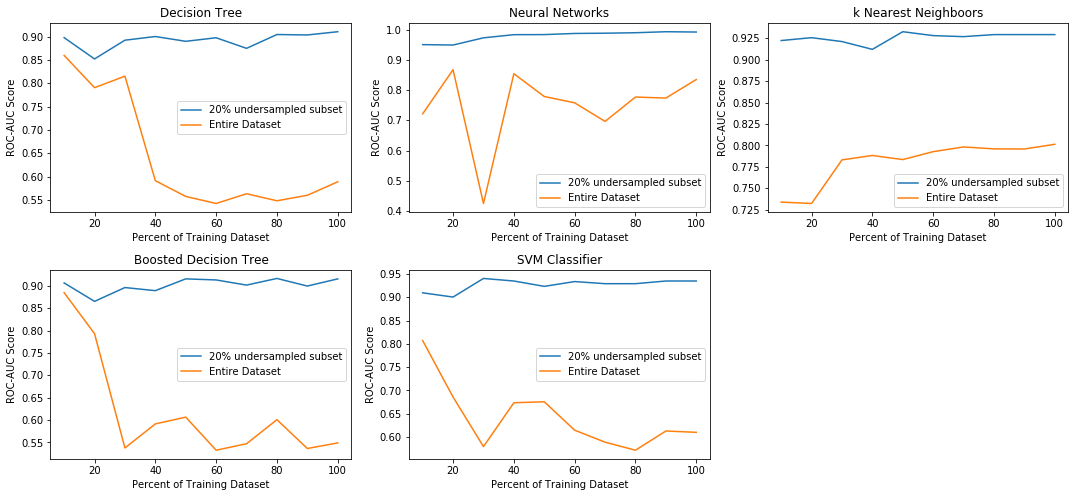

In [16]:
plt.figure(figsize=(15,10))
plotForAlgo(plt, 0, "Decision Tree")
plotForAlgo(plt, 1, "Neural Networks")
plotForAlgo(plt, 2, "k Nearest Neighboors")
plotForAlgo(plt, 3, "Boosted Decision Tree")
plotForAlgo(plt, 4, "SVM Classifier")



plt.tight_layout()
plt.show()

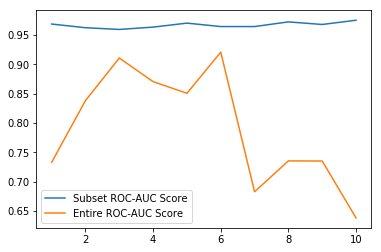

In [101]:
plotForAlgo(1)

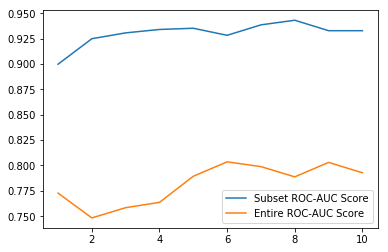

In [102]:
plotForAlgo(2)

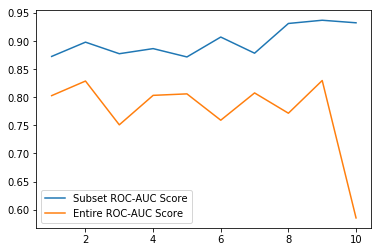

In [103]:
plotForAlgo(3)

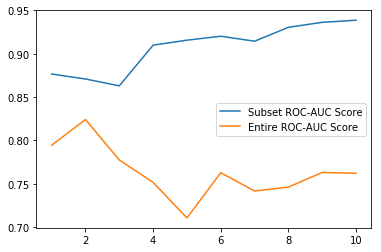

In [104]:
plotForAlgo(4)